In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt
from utils import optimize_channel

In [2]:
data_dir = create_directory(directory_name='loss0_if') # loss0_if

0.029328532292015715


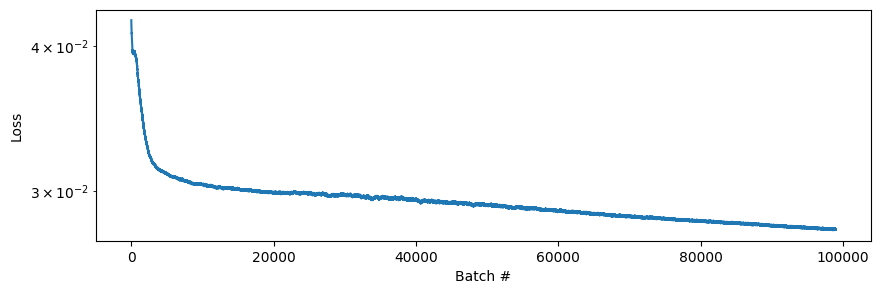

In [3]:
model_num = 0
model_name = "model{:02d}".format(model_num)

phase = 'FF1'
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log,'position',w=1)
fig.savefig(os.path.join(data_dir,'loss_FF1.png'),dpi=300)

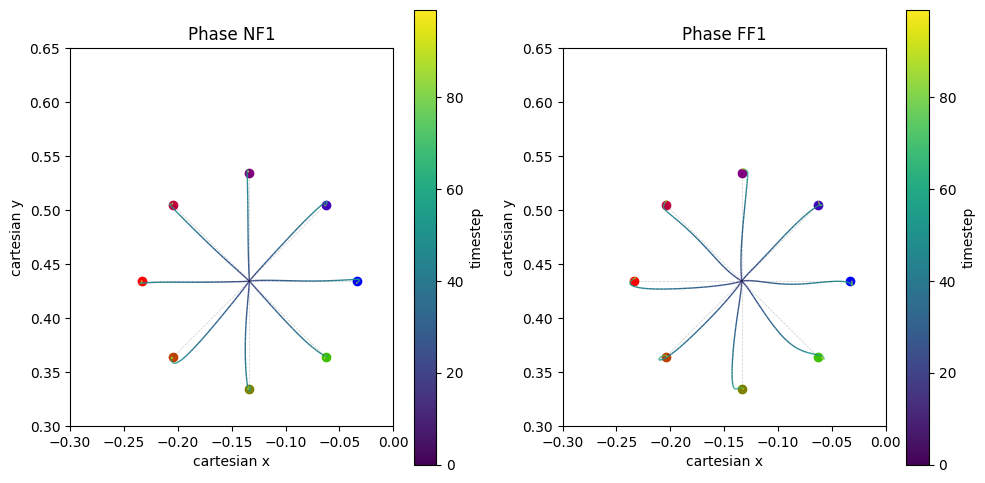

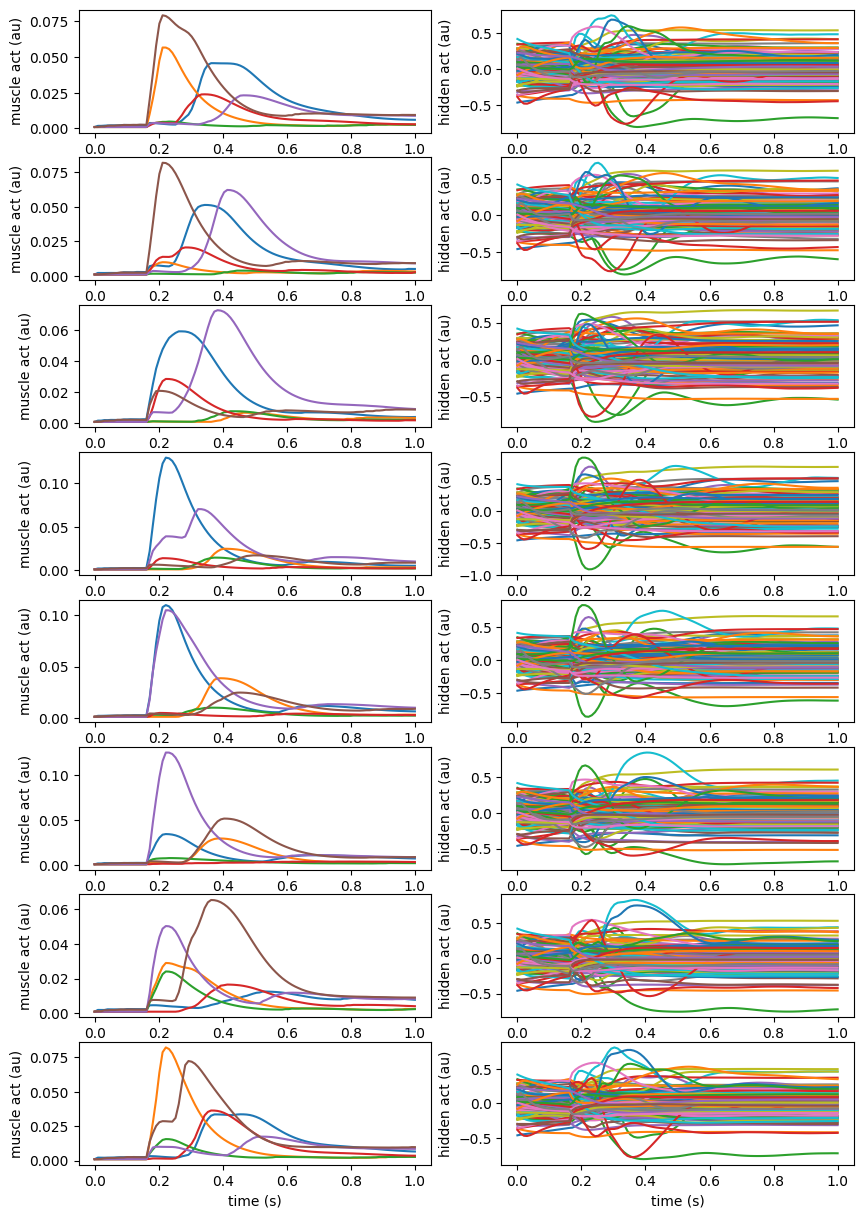

In [4]:
model_num = 15
# pert - input fix [0,11,13]
# loss0 - [2,3,7,13] 
model_name = "model{:02d}".format(model_num)
data = []
#label = ['NF1','FF1']
label = ['NF1','FF1']
ff = [0,8]
is_channel = False
#K = 870
#B = -5
K = 170
B = -1
dT = 0.01

fig,ax = plt.subplots(1,len(label),figsize=(5*len(label),5))
for i,p in enumerate(label):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i],is_channel=is_channel,K=K,B=B,dT=dT,calc_endpoint_force=True))
    plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    ax[i].set_title(f'Phase {p}')
    #plot.plot_simulations(ax,xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    #ax.set_title(f'Phase {p}')

plt.tight_layout()
#fig.savefig(os.path.join(data_dir,'input_flex_60000.png'),dpi=300)
plt.show()


fig, ax = plot.plot_activation(data[i]['all_hidden'],data[i]['all_muscle'],figsize=(10,15))
#fig.savefig(os.path.join(data_dir,'activation.png'),dpi=300)

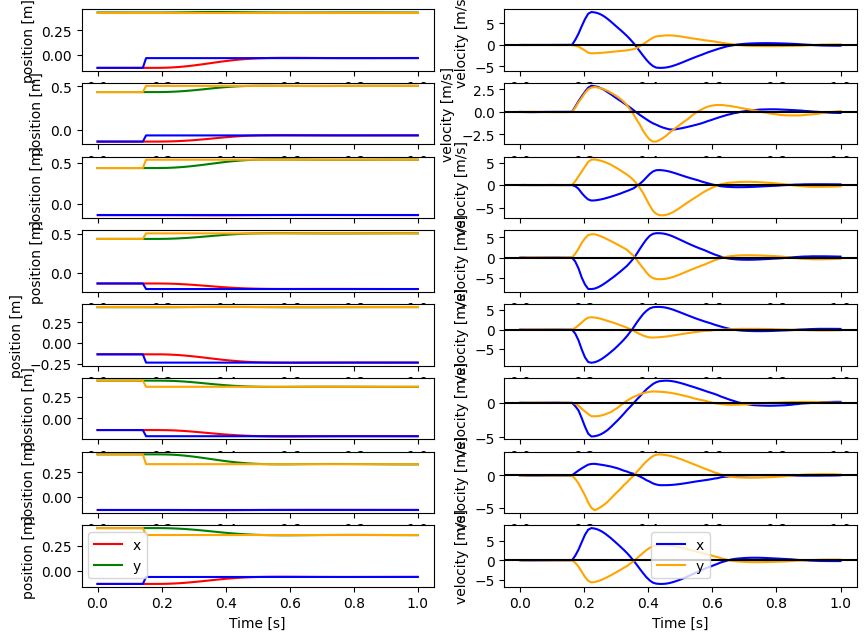

In [7]:
i = 0
fig, ax = plot.plot_kinematic(data[i]['endpoint_force'],data[i]['xy'],data[i]['tg'],figsize=(10,7.5)) # data[i]['vel']
fig.savefig(os.path.join(data_dir,'kinematic.png'),dpi=300)

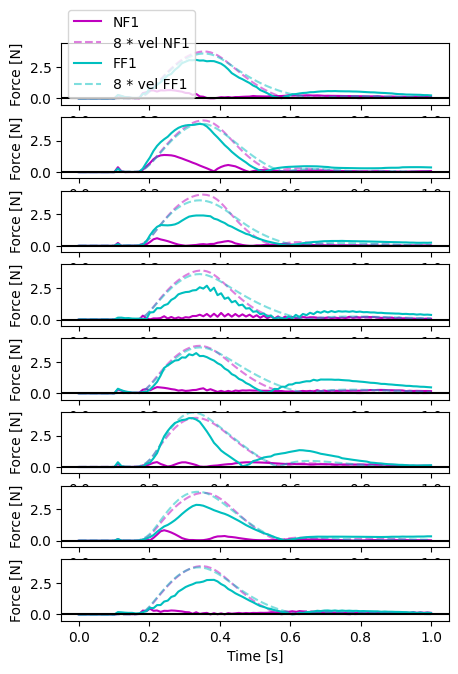

In [28]:
fig, ax = plot.plot_force(data,label,figsize=(5,7.5))
#fig.savefig(os.path.join(data_dir,'lat_force.png'),dpi=300)

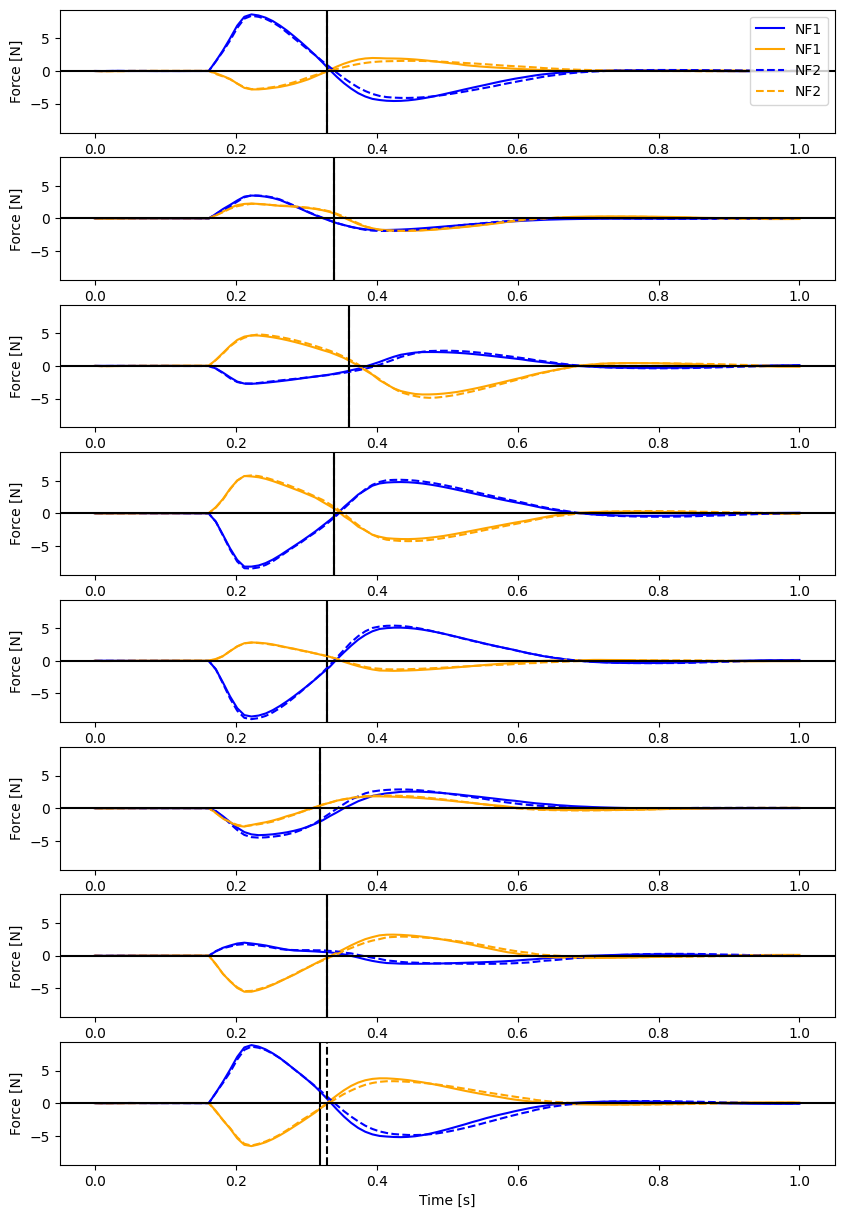

In [23]:
fg, ax = plot_epforce(data,label,figsize=(10,15))

In [22]:
def plot_epforce(data,label,figsize=(10,15)):
    fg, ax = plt.subplots(nrows=8,ncols=1,figsize=figsize)

    color_list = ['blue','orange','red','green']
    style = ['-','--','-.',':']

    x = np.linspace(0, 1, np.shape(data[0]['endpoint_force'])[1])

    max_force = 0
    min_force = 0
    for i in range(8):
        for j in range(len(data)):
            ep = np.array(data[j]['endpoint_force'][i,:,:])
            vel = np.array(data[j]['vel'][i,:,:])
    
            vel_norm = np.linalg.norm(vel,axis=-1)
            max_vel_idx = np.argmax(vel_norm)/100


            if np.max(ep)>max_force:
                max_force = np.max(ep)
            if np.min(ep)<min_force:
                min_force = np.min(ep)
            
            ax[i].plot(x,ep[:,0],color=color_list[0],label=label[j],linestyle=style[j])
            ax[i].plot(x,ep[:,1],color=color_list[1],label=label[j],linestyle=style[j])

            ax[i].axvline(x=max_vel_idx, color='k',linestyle=style[j])


        ax[i].axhline(y=00, color='k')
        ax[i].set_ylabel('Force [N]')

    for i in range(8):
        ax[i].set_ylim([-0.5+min_force,max_force+0.5])
    ax[i].set_xlabel('Time [s]')
    ax[0].legend()
    return fg, ax
